# Image Segmentation using Full Connected Neural Network

By [Akshaj Verma](https://akshajverma.com)


This notebook takes you through an implementation of paper [Fully Convolutional Network for Semantic Segmentation](https://arxiv.org/pdf/1411.4038.pdf) on the [Chest X-Ray dataset](https://www.kaggle.com/ianmoone0617/chest-x-ray-image-segmentation-with-lungs-mask).

In [2]:
import pathlib
from tqdm.notebook import tqdm

import cv2
from PIL import Image

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms, utils, datasets
from torch.utils.data import Dataset, DataLoader, random_split, SubsetRandomSampler


from sklearn.metrics import jaccard_score
from sklearn.metrics import classification_report, confusion_matrix

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
np.random.seed(0)
torch.manual_seed(0)

In [4]:
%matplotlib inline
sns.set_style('darkgrid')

## Define Paths and Set GPU

Let's define the path for our data.

In [5]:
ROOT_PATH = "../../../data/computer_vision/image_segmentation/chest-x-ray/"
images_path = ROOT_PATH + "images/"
labels_path = ROOT_PATH + "masks"

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = "cpu"
print("We're using =>", device)

We're using => cuda


## Visualize Data

### Training image

Shape of the image is:  (512, 512, 3) 




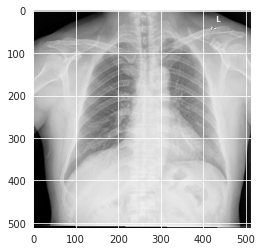

In [7]:
img = Image.open(images_path + "CHNCXR_0001_0.png")
print("Shape of the image is: ", np.array(img).shape, "\n\n")
plt.imshow(img)

### Histogram of image

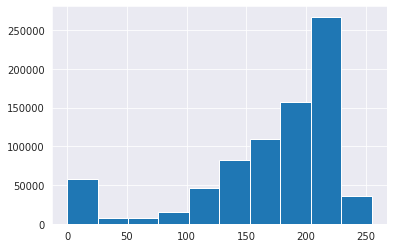

In [8]:
plt.hist(np.array(img).flatten())
plt.show()

### Training label

Shape of the label is:  (224, 224) 




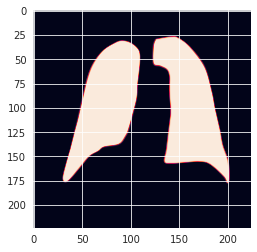

In [9]:
lbl = Image.open(labels_path + "/CHNCXR_0001_0_mask.png").convert('L')
lbl = lbl.resize((224, 224))
print("Shape of the label is: ", np.array(lbl).shape, "\n\n")
plt.imshow(lbl)

### Histogram of label

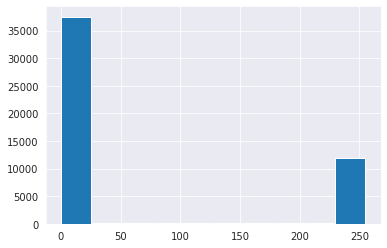

In [10]:
plt.hist(np.array(lbl).flatten())
plt.show()

In [11]:
lbl = np.array(lbl)
lbl[lbl < 255] = 0
lbl[lbl == 255] = 1

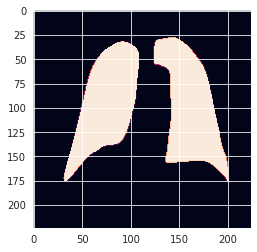

In [12]:
plt.imshow(lbl * 50)

## Data Preprocessing

### Create Transforms

In [13]:
IMAGE_LABEL_SIZE = 224

image_transforms = {
    "train": transforms.Compose([
#         transforms.Resize((IMAGE_LABEL_SIZE, IMAGE_LABEL_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # imagenet
    ]),
    "test": transforms.Compose([
#         transforms.Resize((IMAGE_LABEL_SIZE, IMAGE_LABEL_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # imagenet
    ])
}

### Create Dataset

#### Path to data

In [14]:
root_path = pathlib.Path(ROOT_PATH)

print("Root path: ", root_path)
print("")

# train paths
train_images_path = root_path.joinpath("images")
train_labels_path = root_path.joinpath("masks")

print("Train Images path: ", train_images_path)
print("Train Labels path: ", train_labels_path)
print("")

Root path:  /content/drive/My Drive/data/chest-x-ray

Train Images path:  /content/drive/My Drive/data/chest-x-ray/images
Train Labels path:  /content/drive/My Drive/data/chest-x-ray/masks



#### Base Dataset Class

In [15]:
class DatasetChestXray(Dataset):
    def __init__(self, images_path, labels_path, image_transform, img_lbl_size):
        super(DatasetChestXray, self).__init__()
        self.images_path = pathlib.Path(images_path)
        self.labels_path = pathlib.Path(labels_path)
        
        self.img_lbl_size = img_lbl_size
        self.transform = image_transform
        
        self.img_file_paths = [file for file in images_path.rglob("**/*.png")]
        self.lbl_file_paths = [file for file in labels_path.rglob("**/*.png")]
        
    def __getitem__(self, idx):
        img_path = str(self.img_file_paths[idx])
        lbl_path = str(self.lbl_file_paths[idx])
                
        img = Image.open(img_path).resize((IMAGE_LABEL_SIZE, IMAGE_LABEL_SIZE))
        img = self.transform(img)
        
        lbl = Image.open(lbl_path).convert('L').resize((IMAGE_LABEL_SIZE, IMAGE_LABEL_SIZE))
        lbl = np.array(lbl)
        lbl[lbl < 255] = 0
        lbl[lbl == 255] = 1

        lbl = torch.from_numpy(lbl).long()
        
        return img, lbl
    
    def __len__(self):
        assert len(self.img_file_paths) == len(self.lbl_file_paths)
        return len(self.img_file_paths)

#### Train - Val - Test Split

In [16]:
train_test_dataset = DatasetChestXray(images_path=train_images_path, labels_path=train_labels_path, image_transform=image_transforms["train"], img_lbl_size=IMAGE_LABEL_SIZE)

We use `SubsetRandomSampler` to make our train and validation loaders. `SubsetRandomSampler` is used so that our each batch receives a random distribution of classes.

`SubsetRandomSampler(indices)` takes as input the indices of data.

We first create our samplers and then we'll pass it to our dataloaders.

* Create a list of indices.
* Shuffle the indices.
* Split the indices based on train-val percentage.
* Create SubsetRandomSampler.

In [17]:
def create_samplers(dataset, train_percent, val_percent):
    # Create a list of indices from 0 to length of dataset.
    dataset_size = len(dataset)
    dataset_indices = list(range(dataset_size))
    
    # Shuffle the list of indices using `np.shuffle`.
    np.random.shuffle(dataset_indices)
    
    # Create the split index. We choose the split index to be 20% (0.2) of the dataset size.
    train_split_index = int(np.floor(train_percent * dataset_size))
    val_split_index = int(np.floor(val_percent * dataset_size))
    

    # Slice the lists to obtain 2 lists of indices, one for train and other for test.
    # `0-------------------------- train_idx----- val_idx ---------n`

    train_idx = dataset_indices[:train_split_index]
    val_idx = dataset_indices[train_split_index:train_split_index+val_split_index]
    test_idx = dataset_indices[train_split_index+val_split_index:]
    
    # Finally, create samplers.
    train_sampler = SubsetRandomSampler(train_idx)
    val_sampler = SubsetRandomSampler(val_idx)
    test_sampler = SubsetRandomSampler(test_idx)
    
    return train_sampler, val_sampler, test_sampler

In [18]:
train_sampler, val_sampler, test_sampler = create_samplers(train_test_dataset, 0.8, 0.1)

### Create Dataloaders

In [19]:
train_loader = DataLoader(dataset=train_test_dataset, shuffle=False, batch_size=8, sampler = train_sampler)
val_loader = DataLoader(dataset=train_test_dataset, shuffle=False, batch_size=1, sampler = val_sampler)
test_loader = DataLoader(dataset=train_test_dataset, shuffle=False, batch_size=1, sampler = test_sampler)

### Data Sanity Check

In [20]:
print("Shape of image from train-loader = ", next(iter(train_loader))[0].shape)
print("Shape of label from train-loader = ", next(iter(train_loader))[1].shape)

print("\nShape of image from val-loader = ", next(iter(val_loader))[0].shape)
print("Shape of label from val-loader = ", next(iter(val_loader))[1].shape)

print("\nShape of image from test-loader = ", next(iter(test_loader))[0].shape)
print("Shape of label from test-loader = ", next(iter(test_loader))[1].shape)

Shape of image from train-loader =  torch.Size([8, 3, 224, 224])
Shape of label from train-loader =  torch.Size([8, 224, 224])

Shape of image from val-loader =  torch.Size([1, 3, 224, 224])
Shape of label from val-loader =  torch.Size([1, 224, 224])

Shape of image from test-loader =  torch.Size([1, 3, 224, 224])
Shape of label from test-loader =  torch.Size([1, 224, 224])


## FCN Model

In [21]:
class ModelFCN8(nn.Module):
    def __init__(self, num_class):
        super(ModelFCN8, self).__init__()
        self.num_class = num_class
        
        self.block_1_1 = self.conv_block(c_in=3, c_out=64, kernel_size=3, stride=1, padding=1)
        self.block_1_2 = self.conv_block(c_in=64, c_out=64, kernel_size=3, stride=1, padding=1)
        
        self.block_2_1 = self.conv_block(c_in=64, c_out=128, kernel_size=3, stride=1, padding=1)
        self.block_2_2 = self.conv_block(c_in=128, c_out=128, kernel_size=3, stride=1, padding=1)
        self.block_2_3 = self.conv_block(c_in=128, c_out=128, kernel_size=3, stride=1, padding=1)
        
        self.block_3_1 = self.conv_block(c_in=128, c_out=256, kernel_size=3, stride=1, padding=1)
        self.block_3_2 = self.conv_block(c_in=256, c_out=256, kernel_size=3, stride=1, padding=1)
        self.block_3_3 = self.conv_block(c_in=256, c_out=256, kernel_size=3, stride=1, padding=1)
        
        self.block_4_1 = self.conv_block(c_in=256, c_out=512, kernel_size=3, stride=1, padding=1)
        self.block_4_2 = self.conv_block(c_in=512, c_out=512, kernel_size=3, stride=1, padding=1)
        self.block_4_3 = self.conv_block(c_in=512, c_out=512, kernel_size=3, stride=1, padding=1)
        
        self.block_5_1 = self.conv_block(c_in=512, c_out=512, kernel_size=3, stride=1, padding=1)
        self.block_5_2 = self.conv_block(c_in=512, c_out=512, kernel_size=3, stride=1, padding=1)
        self.block_5_3 = self.conv_block(c_in=512, c_out=512, kernel_size=3, stride=1, padding=1)
        
        self.conv1x1_512_4096 = nn.Conv2d(in_channels=512, out_channels=4096, kernel_size=1, stride=1, padding=0)
        
        
        self.conv1x1_4096_numclass = nn.Conv2d(in_channels=4096, out_channels=num_class, kernel_size=1, stride=1, padding=0)
        self.conv1x1_512_numclass = nn.Conv2d(in_channels=512, out_channels=num_class, kernel_size=1, stride=1, padding=0)
        self.conv1x1_256_numclass = nn.Conv2d(in_channels=256, out_channels=num_class, kernel_size=1, stride=1, padding=0)
        
        self.upsample_pool5_2x = nn.ConvTranspose2d(in_channels=num_class, out_channels=num_class, kernel_size=2, stride=2)
        self.upsample_pool4_2x = nn.ConvTranspose2d(in_channels=num_class, out_channels=num_class, kernel_size=2, stride=2)
        self.upsample_pool3_8x = nn.ConvTranspose2d(in_channels=num_class, out_channels=num_class, kernel_size=8, stride=8)
        
        self.final_conv = nn.Conv2d(in_channels=num_class, out_channels=num_class, kernel_size=3, stride=1, padding=1)
        
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        
    
    def forward(self, x):
                              # 3 x 224 x 224
        x1 = self.block_1_1(x)
        x1 = self.block_1_2(x1)
        
        x1 = self.maxpool(x1) # 64 x 112 x 112
        
        x2 = self.block_2_1(x1)
        x2 = self.block_2_2(x2)
        x2 = self.block_2_3(x2)
        
        x2 = self.maxpool(x2) # 128 x 56 x 56
        
        x3 = self.block_3_1(x2)
        x3 = self.block_3_2(x3)
        x3 = self.block_3_3(x3)
        
        x3 = self.maxpool(x3) # 256 x 28 x 28
        p3 = self.conv1x1_256_numclass(x3) # 8 x 28 x 28
        
        x4 = self.block_4_1(x3)
        x4 = self.block_4_2(x4)
        x4 = self.block_4_3(x4)
        
        x4 = self.maxpool(x4) # 512 x 14 x 14
        p4 = self.conv1x1_512_numclass(x4) # 8 x 14 x 14
        
        x5 = self.block_5_1(x4)
        x5 = self.block_5_2(x5)
        x5 = self.block_5_3(x5) 
        
        x5 = self.maxpool(x5) # 512 x 7 x 7
        
        x5 = self.conv1x1_512_4096(x5) # 4096 x 7 x 7
        p5 = self.conv1x1_4096_numclass(x5) # 8 x 7 x 7
        
        
        # Upsampling using transposed convolutions
        o1 = self.upsample_pool5_2x(p5) # 8 x 14 x14
        o1 = o1 + p4
        o2 = self.upsample_pool4_2x(o1) # 8 x 28 x 28
        o2 = o2 + p3
        o3 = self.upsample_pool3_8x(o2) # 8 x 224 x 224
        
        
        output = self.final_conv(o3) # 8 x 224 x 224


        return output

        
    def conv_block(self, c_in, c_out, **kwargs):
        seq_block = nn.Sequential(
            nn.Conv2d(in_channels=c_in, out_channels=c_out, **kwargs),
            nn.BatchNorm2d(num_features=c_out),
            nn.ReLU()
        )
        
        return seq_block

In [22]:
model = ModelFCN8(num_class=2)
model.to(device)
print(model)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=0.0005)

ModelFCN8(
  (block_1_1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (block_1_2): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (block_2_1): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (block_2_2): Sequential(
    (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (block_2_3): Sequential(
    (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, 

In [23]:
loss_stats = {
    'train': [],
    "val": []
}

In [24]:
EPOCHS = 100

In [25]:
print("Begin training.")

for e in tqdm(range(1, EPOCHS+1)):
    
    # TRAINING
    train_epoch_loss = 0
    
    model.train()
    for X_train_batch, y_train_batch in train_loader:
        X_train_batch, y_train_batch = X_train_batch.to(device), y_train_batch.to(device)
        optimizer.zero_grad()
        
        y_train_pred = model(X_train_batch)
        
        train_loss = criterion(y_train_pred, y_train_batch)
        
        train_loss.backward()
        optimizer.step()
        
        train_epoch_loss += train_loss.item()
        
        
    # VALIDATION
    with torch.no_grad():
        model.eval()
        val_epoch_loss = 0
        val_epoch_acc = 0
        for X_val_batch, y_val_batch in val_loader:
            X_val_batch, y_val_batch = X_val_batch.to(device), y_val_batch.to(device)
            
            y_val_pred = model(X_val_batch)
                                    
            val_loss = criterion(y_val_pred, y_val_batch)
            
            val_epoch_loss += train_loss.item()

    
    if e%5 == 0:
        model_name = "model_idd_seg_fcn8_" + str(e)
        torch.save(model, model_name)
        
    loss_stats['train'].append(train_epoch_loss/len(train_loader))
    loss_stats['val'].append(val_epoch_loss/len(val_loader))
                        
    print(f'Epoch {e+0:02}: | Train Loss: {train_epoch_loss/len(train_loader):.5f} | Val Loss: {val_epoch_loss/len(val_loader):.5f}')

Begin training.


Epoch 01: | Train Loss: 0.56166 | Val Loss: 0.53784
Epoch 02: | Train Loss: 0.38116 | Val Loss: 0.36263
Epoch 03: | Train Loss: 0.31075 | Val Loss: 0.27214
Epoch 04: | Train Loss: 0.28782 | Val Loss: 0.23129


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type ModelFCN8. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch 05: | Train Loss: 0.27241 | Val Loss: 0.27040
Epoch 06: | Train Loss: 0.26098 | Val Loss: 0.23576
Epoch 07: | Train Loss: 0.25119 | Val Loss: 0.25276
Epoch 08: | Train Loss: 0.24699 | Val Loss: 0.21426
Epoch 09: | Train Loss: 0.24479 | Val Loss: 0.28648
Epoch 10: | Train Loss: 0.24244 | Val Loss: 0.23907
Epoch 11: | Train Loss: 0.23654 | Val Loss: 0.21753
Epoch 12: | Train Loss: 0.23300 | Val Loss: 0.20597
Epoch 13: | Train Loss: 0.22988 | Val Loss: 0.29661
Epoch 14: | Train Loss: 0.22542 | Val Loss: 0.22221
Epoch 15: | Train Loss: 0.22230 | Val Loss: 0.21950
Epoch 16: | Train Loss: 0.21970 | Val Loss: 0.25257
Epoch 17: | Train Loss: 0.21936 | Val Loss: 0.23835
Epoch 18: | Train Loss: 0.20834 | Val Loss: 0.20219
Epoch 19: | Train Loss: 0.20720 | Val Loss: 0.22731
Epoch 20: | Train Loss: 0.20168 | Val Loss: 0.23003
Epoch 21: | Train Loss: 0.19345 | Val Loss: 0.17084
Epoch 22: | Train Loss: 0.18662 | Val Loss: 0.17980
Epoch 23: | Train Loss: 0.17921 | Val Loss: 0.20828
Epoch 24: | 

Text(0.5, 1.0, 'Train-Val Loss/Epoch')

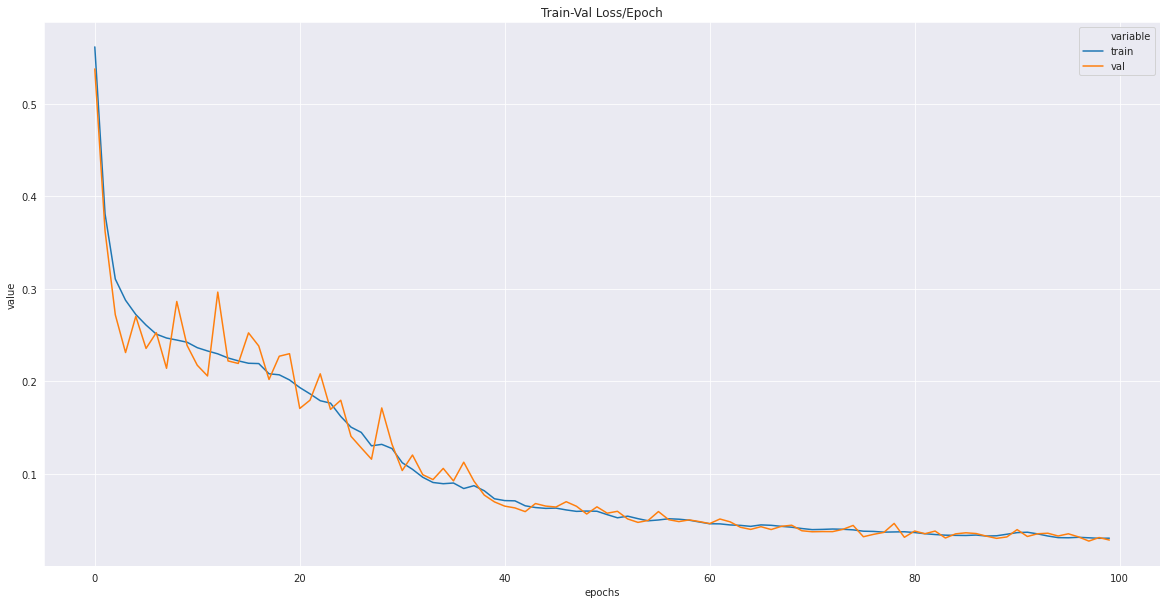

In [35]:
train_val_loss_df = pd.DataFrame.from_dict(loss_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})

plt.figure(figsize = (20,10))
sns.lineplot(data=train_val_loss_df, x = "epochs", y="value", hue="variable").set_title('Train-Val Loss/Epoch')

In [26]:
y_pred_list = []
y_true_list = []
with torch.no_grad():
    for x_batch, y_batch in tqdm(test_loader):
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        
        y_test_pred = model(x_batch)
        
        y_test_pred = torch.log_softmax(y_test_pred, dim=1)
        _, y_pred_tag = torch.max(y_test_pred, dim = 1)
    
        y_pred_list.append(y_pred_tag.cpu().numpy())
        y_true_list.append(y_batch.cpu().numpy())

In [27]:
total_iou = 0

for i in range(len(y_pred_list)):
    temp_iou = jaccard_score(y_true_list[i].squeeze().flatten(), y_pred_list[i].squeeze().flatten(), average="macro")
    total_iou += temp_iou

In [28]:
print("Cumulative IOU = ", total_iou/len(y_pred_list))

Cumulative IOU =  0.7334440737558422


In [29]:
def array_to_img_for_viz(arr):
    arr = arr * 41
    arr = arr.squeeze()
    arr = np.uint8(arr)
    arr_img = Image.fromarray(arr)
    
    return arr_img  

Text(0.5, 1.0, 'Predicted Mask')

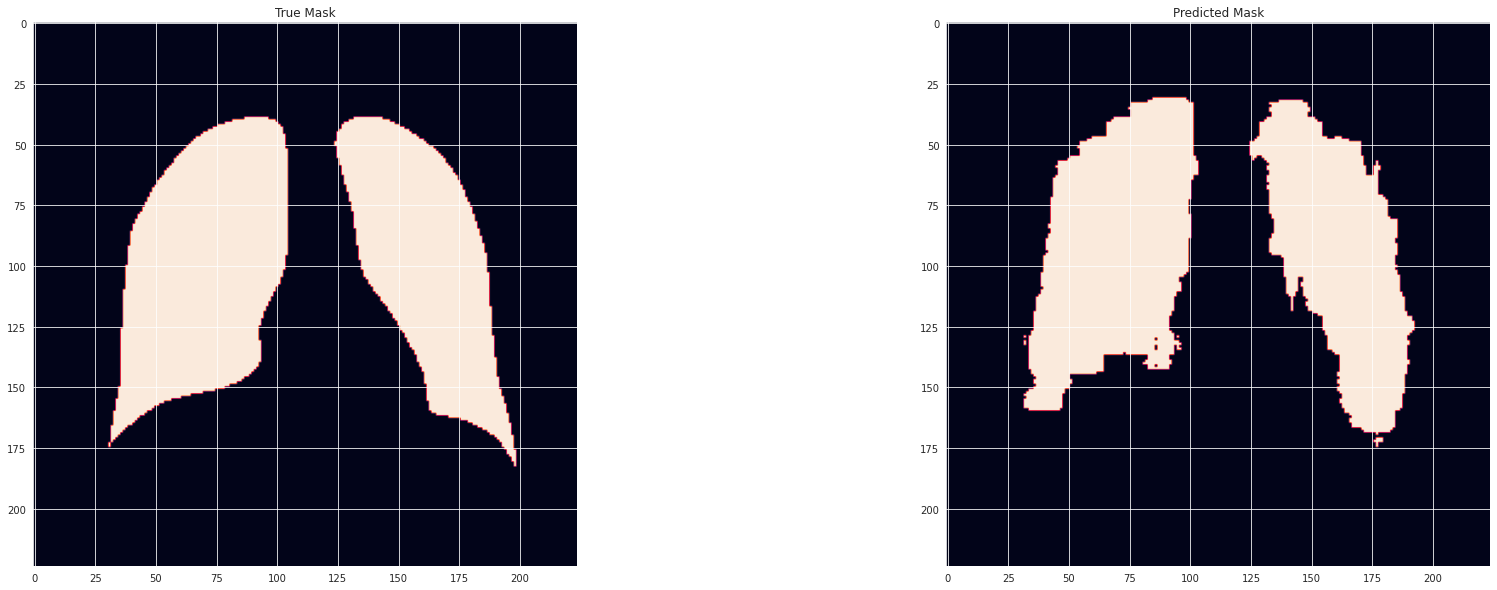

In [30]:
image_index_to_view = 1


fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(30,10))
axes[0].imshow(array_to_img_for_viz(y_true_list[image_index_to_view]))
axes[0].set_title("True Mask")
axes[1].imshow(array_to_img_for_viz(y_pred_list[image_index_to_view]))
axes[1].set_title("Predicted Mask")